In [1]:
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

PATH = "./data"
Lead_ACC = pickle.load(open(f"{PATH}/ACC_24.pickle", "rb"))
Lead_RMSD_arr = pickle.load(open(f"{PATH}/RMSE_24.pickle", "rb"))

levels = ["z", "t", "t2m", "u10", "v10"]

list_acc = []
list_rmse = []
lead_time = []
metric = []
for idx, lev in enumerate(levels):
    for i in range(len(Lead_ACC[lev]) - 1):  # car dernière liste tjr vide
        for j in range(len(Lead_ACC[lev][i])):
            acc = Lead_ACC[lev][i][j]
            rmse = Lead_RMSD_arr[lev][i][j]
            if np.isnan(acc):
                continue
            if np.isnan(rmse):
                continue

            list_acc.append(acc)
            list_rmse.append(rmse)
            lead_time.append(i * 6)
            metric.append(lev)
df_acc = pd.DataFrame(
    {
        "acc": list_acc,
        "lead time": lead_time,
        "variable": metric,
    }
)
df_acc["model"] = "ClimODE"
df_rmse = pd.DataFrame(
    {
        "rmse": list_rmse,
        "lead time": lead_time,
        "variable": metric,
    }
)
df_rmse["model"] = "ClimODE"


other_model_acc = pd.read_csv(f"{PATH}/other_model_acc.csv")
df_acc = pd.concat([df_acc, other_model_acc]).reset_index(drop=True)
other_model_rmse = pd.read_csv(f"{PATH}/other_model_rmse.csv")
df_rmse = pd.concat([df_rmse, other_model_rmse]).reset_index(drop=True)

var_list = ["2m_temperature", "temperature", "geopotential", "10m_u_component_of_wind"]
dict_var = {
    "t2m": "2m_temperature",
    "t": "temperature",
    "z": "geopotential",
    "u10": "10m_u_component_of_wind",
}
df_acc = df_acc.replace(dict_var)
df_rmse = df_rmse.replace(dict_var)
df_rmse = df_rmse.drop(index=df_rmse[df_rmse["rmse"] > 1000].index)
df_acc

,acc,lead time,variable,model
0,0.991088,0,geopotential,ClimODE
1,0.990470,0,geopotential,ClimODE
2,0.990147,0,geopotential,ClimODE
3,0.990423,0,geopotential,ClimODE
4,0.991839,0,geopotential,ClimODE
...,...,...,...,...
13752,0.930000,120,temperature,IFS
13753,0.980000,6,10m_u_component_of_wind,IFS
13754,0.970000,24,10m_u_component_of_wind,IFS
13755,0.890000,72,10m_u_component_of_wind,IFS


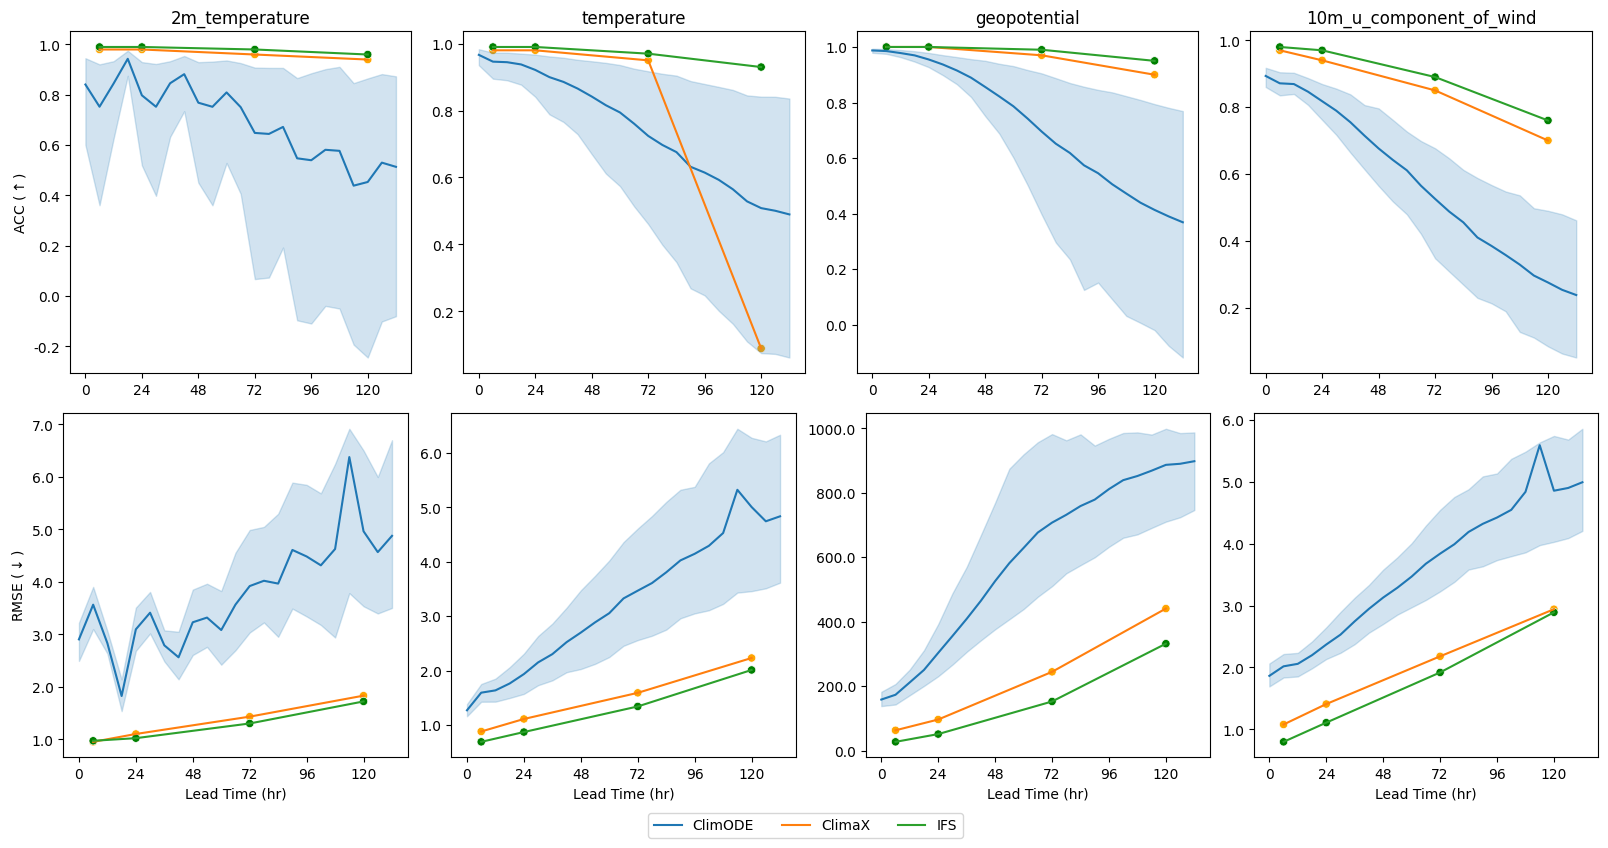

In [20]:
from matplotlib.ticker import FuncFormatter


# Define a function to format the ticks as decimal numbers
def format_y_ticks(y, _):
    return f"{y:.1f}"  # Format y with one decimal place


# Create the main figure and subfigures for each row
fig = plt.figure(constrained_layout=True, figsize=(8 * 2, 8))
subfigs = fig.subfigures(nrows=2, ncols=1)

# Titles for each column and row
column_titles = var_list

# Loop through each subfigure to create subplots
for row, subfig in enumerate(subfigs):
    axs = subfig.subplots(nrows=1, ncols=4)

    for col, ax in enumerate(axs):
        if row == 1:
            metric = "rmse"
            df = df_rmse
        else:
            metric = "acc"
            df = df_acc
        filters = df["variable"] == var_list[col]
        sns.scatterplot(
            data=df[(filters) & (df["model"] != "ClimODE")],
            x="lead time",
            y=metric,
            hue="model",
            ax=ax,
            legend=False,
            palette=["orange", "green"],
        )
        sns.lineplot(
            data=df[filters],
            x="lead time",
            y=metric,
            hue="model",
            errorbar="pi",
            ax=ax,
            legend=False,
        )
        ax.set_xticks(np.arange(0, df_acc["lead time"].max() + 1, 24))
        # Add a title to the first subplot of each row to act as a column title
        if row == 0:
            ax.set_title(column_titles[col])
            ax.set_xlabel("")
            ax.set_ylabel(r"ACC ($\uparrow$)")
        else:
            ax.set_xlabel("Lead Time (hr)")
            ax.set_ylabel(r"RMSE ($\downarrow$)")
        if col != 0:
            ax.set_ylabel("")
        ax.set_box_aspect(1)
        ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))

# Optional: Create a shared legend for the figure
fig.legend(
    handles=axs[0].lines,
    labels=["ClimODE", "ClimaX", "IFS"],
    loc="lower center",
    bbox_to_anchor=(0.5, -0.05),
    ncol=3,
)
# plt.tight_layout()
plt.savefig("./figs/acc_rmse.pdf", bbox_inches="tight", dpi=600)

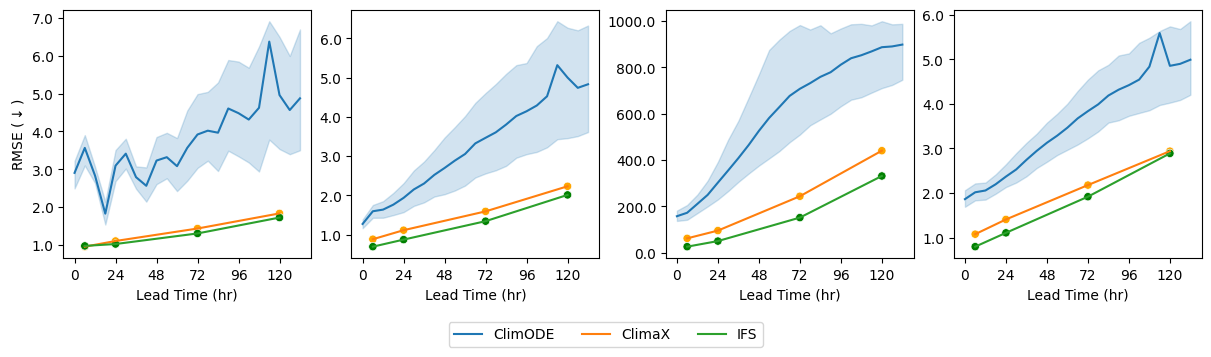

In [10]:
# Create the main figure and subfigures for each row
fig = plt.figure(constrained_layout=True, figsize=(12, 10))

# Titles for each column and row
column_titles = var_list

# Loop through each subfigure to create subplots
axs = fig.subplots(nrows=1, ncols=4)

metric = "rmse"
df = df_rmse
for col, ax in enumerate(axs):
    # if row == 1:
    # else:
    #     metric = "acc"
    #     df = df_acc
    filters = df["variable"] == var_list[col]
    sns.scatterplot(
        data=df[(filters) & (df["model"] != "ClimODE")],
        x="lead time",
        y=metric,
        hue="model",
        ax=ax,
        legend=False,
        palette=["orange", "green"],
    )
    sns.lineplot(
        data=df[filters],
        x="lead time",
        y=metric,
        hue="model",
        errorbar="pi",
        ax=ax,
        legend=False,
    )
    ax.set_xticks(np.arange(0, df_acc["lead time"].max() + 1, 24))
    # Add a title to the first subplot of each row to act as a column title
    ax.set_xlabel("Lead Time (hr)")
    # ax.set_yscale("log")
    ax.yaxis.set_major_formatter(FuncFormatter(format_y_ticks))
    ax.set_ylabel(r"RMSE ($\downarrow$)")
    if col != 0:
        ax.set_ylabel("")
    ax.set_box_aspect(1)

# Optional: Create a shared legend for the figure
fig.legend(
    handles=axs[0].lines,
    labels=["ClimODE", "ClimaX", "IFS"],
    loc="lower center",
    bbox_to_anchor=(0.5, 0.28),
    ncol=3,
)
# plt.tight_layout()
plt.savefig("./figs/rmse.pdf", bbox_inches="tight", dpi=600)

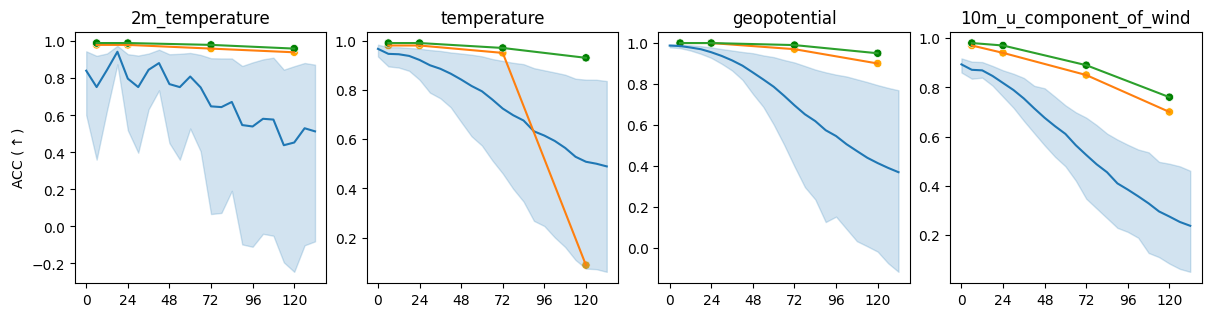

In [49]:
# Create the main figure and subfigures for each row
fig = plt.figure(constrained_layout=True, figsize=(12, 9))

# Titles for each column and row
column_titles = var_list

# Loop through each subfigure to create subplots
axs = fig.subplots(nrows=1, ncols=4)

metric = "acc"
df = df_acc
for col, ax in enumerate(axs):
    # if row == 1:
    # else:
    #     metric = "acc"
    #     df = df_acc
    filters = df["variable"] == var_list[col]
    sns.scatterplot(
        data=df[(filters) & (df["model"] != "ClimODE")],
        x="lead time",
        y=metric,
        hue="model",
        ax=ax,
        legend=False,
        palette=["orange", "green"],
    )
    sns.lineplot(
        data=df[filters],
        x="lead time",
        y=metric,
        hue="model",
        errorbar="pi",
        ax=ax,
        legend=False,
    )
    ax.set_xticks(np.arange(0, df_acc["lead time"].max() + 1, 24))
    # Add a title to the first subplot of each row to act as a column title
    ax.set_title(column_titles[col])
    ax.set_xlabel("")
    ax.set_ylabel(r"ACC ($\uparrow$)")
    if col != 0:
        ax.set_ylabel("")
    ax.set_box_aspect(1)

# Optional: Create a shared legend for the figure
# fig.legend(
#     handles=axs[0].lines,
#     labels=["ClimODE", "ClimaX", "IFS"],
#     loc="lower center",
#     bbox_to_anchor=(0.5, 0.2),
#     ncol=3,
# )
# plt.tight_layout()
plt.savefig("./figs/acc.pdf", bbox_inches="tight", dpi=600)

In [52]:
import numpy as np
import pandas as pd

# Data array
data = np.array(
    [
        [0.27, 0.18, 0.34, 0.31, 0.69, 0.45],  # Time (s)
        [10.2, 15.7, 11.8, 17.8, 13.7, 30.1],  # VRAM (Gb)
    ]
)

# MultiIndex for columns (Solver and Adjoints)
columns = pd.MultiIndex.from_product(
    [["Euler", "RK4", "Implicit Adams"], ["w", "w/o"]], names=["Solver", "Adjoints"]
)

# Index for rows
index = ["Time (s)", "VRAM (Gb)"]

# Create the DataFrame
df_multi_col = pd.DataFrame(data, index=index, columns=columns)

In [53]:
# Apply background gradient across the DataFrame correctly with MultiIndex columns
styled_df_multi_col = df_multi_col.style.background_gradient(
    cmap="Oranges", axis=1
)  # Apply gradient across columns for each row
(
    styled_df_multi_col.format(subset="Euler", precision=2)
    .format(subset="RK4", precision=2)
    .format(subset="Implicit Adams", precision=2)
    .format_index(escape="latex", axis=1)
    .format_index(escape="latex", axis=0)
)
styled_df_multi_col

In [51]:
with open("table.tex", "w") as f:
    f.write(
        styled_df_multi_col.to_latex(
            clines="skip-last;data",
            convert_css=True,
            position_float="centering",
            multicol_align="c",
        )
    )